# 1. Load Libraries and Sample Data

In [1]:
import keras
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import datetime
import yfinance as yf
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

from tqdm.notebook import tqdm
from collections import deque
from IPython.display import display, HTML
from sklearn.preprocessing import StandardScaler

keras.utils.set_random_seed(42)

# Display
pd.set_option('display.max_rows', None)

def display_df(df):
    # Puts scrollbar to dataframe
    display(HTML("<div style='height: 200px; overflow: auto; width: fit-content'>" + df.to_html()+ "</div>"))

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
data = yf.download('GOOG', start='2010-01-01', end='2010-12-31')

[*********************100%***********************]  1 of 1 completed


# 2. Exploratory Data Analysis

In [4]:
display_df(data)

Price,Close,High,Low,Open,Volume
Ticker,GOOG,GOOG,GOOG,GOOG,GOOG
Date,,,,,
2010-01-04,15.494031,15.562261,15.431980,15.498975,78541293
2010-01-05,15.425800,15.520977,15.365233,15.504660,120638494
2010-01-06,15.036936,15.472029,14.989966,15.472029,159744526
2010-01-07,14.686883,15.079951,14.651037,15.065118,257533695
2010-01-08,14.882675,14.913082,14.563524,14.634968,189680313
2010-01-11,14.860180,14.942996,14.685401,14.942996,289597429
2010-01-12,14.597392,14.787251,14.536084,14.774644,194859654
2010-01-13,14.513587,14.545477,14.187515,14.251542,260838034


In [5]:
# Index by Date
data.index = pd.to_datetime(data.index)

In [6]:
data.columns = data.columns.droplevel(1)

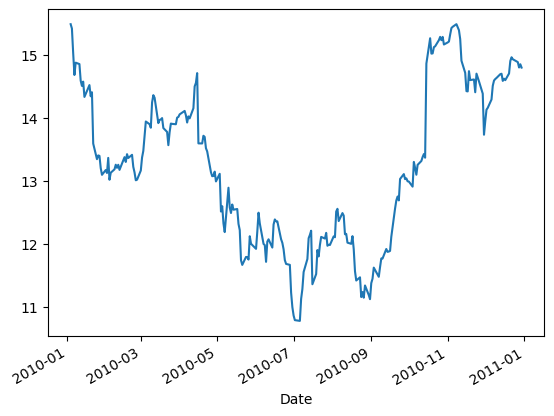

In [7]:
# Plot the close data
data['Close'].plot()
plt.show()

# 3. Data Cleaning

In [8]:
data.isnull().sum()

,0
Price,
Close,0
High,0
Low,0
Open,0
Volume,0


In [9]:
# Forward fill missing value
data = data.ffill()

In [10]:
# Check for missing value
data.isnull().sum()

,0
Price,
Close,0
High,0
Low,0
Open,0
Volume,0


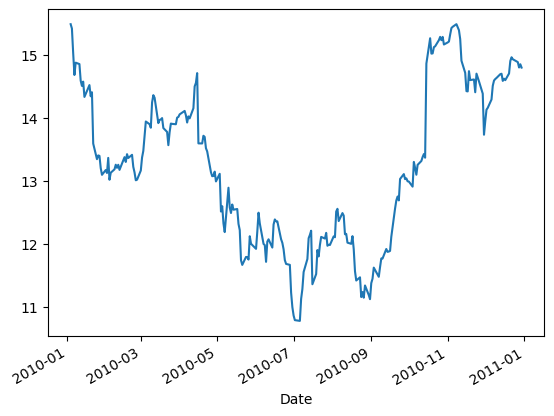

In [11]:
# Plot the close data
data['Close'].plot()
plt.show()

# 4. Feature Selection

In [12]:
# Calculate 20 days bollinger bands
data['MA5'] = data['Close'].rolling(window=5).mean()
data['MA20'] = data['Close'].rolling(window=20).mean()
data['STD20'] = data['Close'].rolling(window=20).std()
data['BB_upper'] = data['MA20'] + (data['STD20'] * 2)
data['BB_lower'] = data['MA20'] - (data['STD20'] * 2)

In [13]:
display_df(data)

Price,Close,High,Low,Open,Volume,MA5,MA20,STD20,BB_upper,BB_lower
Date,,,,,,,,,,
2010-01-04,15.494031,15.562261,15.431980,15.498975,78541293,NaN,NaN,NaN,NaN,NaN
2010-01-05,15.425800,15.520977,15.365233,15.504660,120638494,NaN,NaN,NaN,NaN,NaN
2010-01-06,15.036936,15.472029,14.989966,15.472029,159744526,NaN,NaN,NaN,NaN,NaN
2010-01-07,14.686883,15.079951,14.651037,15.065118,257533695,NaN,NaN,NaN,NaN,NaN
2010-01-08,14.882675,14.913082,14.563524,14.634968,189680313,15.105265,NaN,NaN,NaN,NaN
2010-01-11,14.860180,14.942996,14.685401,14.942996,289597429,14.978495,NaN,NaN,NaN,NaN
2010-01-12,14.597392,14.787251,14.536084,14.774644,194859654,14.812813,NaN,NaN,NaN,NaN
2010-01-13,14.513587,14.545477,14.187515,14.251542,260838034,14.708143,NaN,NaN,NaN,NaN
2010-01-14,14.581819,14.689356,14.407780,14.434727,170239717,14.687131,NaN,NaN,NaN,NaN


In [14]:
# Remove nan values
data.dropna(axis=0, inplace=True)
display_df(data)

Price,Close,High,Low,Open,Volume,MA5,MA20,STD20,BB_upper,BB_lower
Date,,,,,,,,,,
2010-02-01,13.176908,13.245882,13.109667,13.215969,90369462,13.259331,14.247389,0.766230,15.779849,12.714929
2010-02-02,13.129941,13.224869,13.043168,13.224869,164462143,13.203461,14.129185,0.745873,15.620930,12.637439
2010-02-03,13.369736,13.401380,13.058495,13.069372,120413655,13.197132,14.026381,0.697906,15.422193,12.630570
2010-02-04,13.022650,13.300021,12.992490,13.275301,135614418,13.160001,13.925667,0.689690,15.305046,12.546288
2010-02-05,13.134142,13.188775,12.915853,13.062698,126713179,13.166675,13.848030,0.686880,15.221790,12.474270
2010-02-08,13.188035,13.398907,13.140076,13.164055,108175956,13.168901,13.763298,0.656377,15.076052,12.450544
2010-02-09,13.261456,13.387288,13.227589,13.338093,113206742,13.195204,13.683362,0.611585,14.906532,12.460192
2010-02-10,13.212261,13.294830,13.045146,13.202867,107380987,13.163709,13.614105,0.580256,14.774617,12.453593
2010-02-11,13.260468,13.361578,13.089892,13.184326,96761331,13.211273,13.551449,0.544577,14.640603,12.462295


In [15]:
# Define new dataframe with close, upper bb and lower bb

dataset = data[['Close', 'BB_upper', 'BB_lower']]

In [16]:
print("Columns:", dataset.columns)
print("Index Name:", dataset.index.name)

Columns: Index(['Close', 'BB_upper', 'BB_lower'], dtype='object', name='Price')
Index Name: Date


# 5. Normalization

*** Try this with rolling scaler as well ***

Price,Close,BB_upper,BB_lower
Date,,,
2010-02-01,13.176908,15.779849,12.714929
2010-02-02,13.129941,15.620930,12.637439
2010-02-03,13.369736,15.422193,12.630570
2010-02-04,13.022650,15.305046,12.546288
2010-02-05,13.134142,15.221790,12.474270
2010-02-08,13.188035,15.076052,12.450544
2010-02-09,13.261456,14.906532,12.460192
2010-02-10,13.212261,14.774617,12.453593
2010-02-11,13.260468,14.640603,12.462295


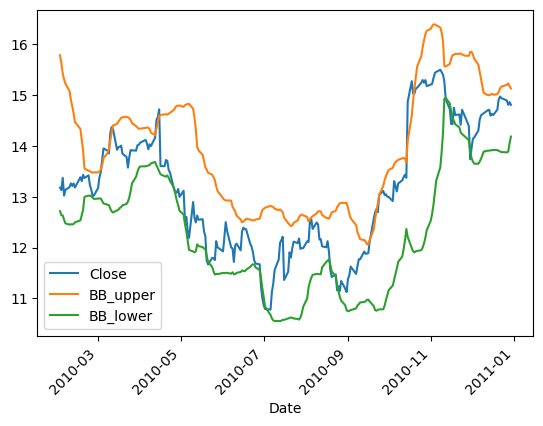

In [17]:
# Display and plot unnormalized data
display_df(dataset)
dataset['Close'].plot()
dataset['BB_upper'].plot()
dataset['BB_lower'].plot(rot=45)
plt.legend()
plt.show()

In [18]:
# Normalize dataset with StandardScaler
# Normalize data with Standard Scalar

normlist = [] # tie back normalized data to the actual closing price
normed_dataset = pd.DataFrame(index = dataset.index)     # Define dataframe to store the normalized data
for col in dataset.columns:
    if col == 'Date':
        normed_dataset[col] = dataset[col]
        continue
    
    normalizer = StandardScaler()
    column_data = pd.DataFrame(dataset[col])
    normalizer.fit(column_data)
    normed_dataset[col] = normalizer.transform(column_data).flatten()
    normlist.append(normalizer)

,Close,BB_upper,BB_lower
Date,,,
2010-02-01,0.023341,1.512162,0.378761
2010-02-02,-0.014623,1.380815,0.311862
2010-02-03,0.179202,1.216559,0.305931
2010-02-04,-0.101346,1.119738,0.233167
2010-02-05,-0.011228,1.050926,0.170991
2010-02-08,0.032334,0.930474,0.150507
2010-02-09,0.091680,0.790366,0.158836
2010-02-10,0.051916,0.681338,0.153140
2010-02-11,0.090882,0.570576,0.160652


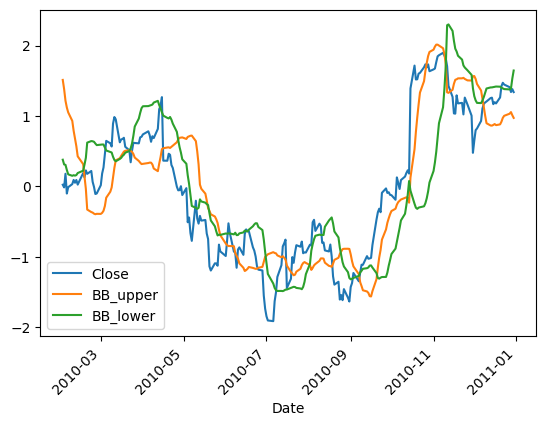

In [19]:
# Display and plot normalized data
display_df(normed_dataset)
normed_dataset['Close'].plot()
normed_dataset['BB_upper'].plot()
normed_dataset['BB_lower'].plot(rot=45)
plt.legend()
plt.show()

# 6. Train/Test Split

In [20]:
# Split 50% data between Train and Test

training_row = int(len(normed_dataset.index) * 0.5)
train_df = normed_dataset.iloc[:training_row,]
test_df = normed_dataset.iloc[training_row+1:,]
print(train_df.shape)
print(test_df.shape)

(116, 3)
(115, 3)


In [21]:
# Display Train and Test dataframes
display_df(train_df)
display_df(test_df)

,Close,BB_upper,BB_lower
Date,,,
2010-02-01,0.023341,1.512162,0.378761
2010-02-02,-0.014623,1.380815,0.311862
2010-02-03,0.179202,1.216559,0.305931
2010-02-04,-0.101346,1.119738,0.233167
2010-02-05,-0.011228,1.050926,0.170991
2010-02-08,0.032334,0.930474,0.150507
2010-02-09,0.091680,0.790366,0.158836
2010-02-10,0.051916,0.681338,0.153140
2010-02-11,0.090882,0.570576,0.160652


,Close,BB_upper,BB_lower
Date,,,
2010-07-20,-1.004338,-1.237510,-1.433630
2010-07-21,-1.086064,-1.262333,-1.426375
2010-07-22,-0.939994,-1.253914,-1.429278
2010-07-23,-0.835089,-1.211169,-1.442000
2010-07-26,-0.856869,-1.170210,-1.450017
2010-07-27,-0.783735,-1.118231,-1.460453
2010-07-28,-0.949188,-1.088486,-1.427304
2010-07-29,-0.936400,-1.075154,-1.355774
2010-07-30,-0.939196,-1.087203,-1.246376


In [22]:
# Convert Train and Test dfs into np array with dtype = Float
X_train = train_df.values.astype(float)
X_test = test_df.values.astype(float)

# print the shape of X_train and X_test to remind yourself how many examples and features are in the dataset
print(X_train.shape)
print(X_test.shape)

# track index to remember which feature is which
idx_close = 0
idx_bb_upper = 1
idx_bb_lower = 2

(116, 3)
(115, 3)


# 7. Define the Agent

## Define DQN Model

In [23]:
# Define DQN model architecture

@keras.saving.register_keras_serializable()

class DQN(keras.Model):
    def __init__(self, state_size, action_size):
        model = keras.models.Sequential()
        # Input layer
        model.add(keras.layers.Dense(units=32, input_dim=state_size, activation='relu'))
        
        # Hidden layer
        model.add(keras.layers.Dense(units=8, activation='relu'))
        
        # Output Layer
        model.add(keras.layers.Dense(action_size, activation='linear'))
        
        # Compile model
        model.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=0.001)) # This can be adjusted based on the learning
        
        # Save model to DQN instance
        self.model = model
    

## Define agent class

In [24]:
# Define Agent

class Agent:
    def __init__(self, window_size, num_features, test_mode=False, model_name=''):
        self.window_size = window_size                  # Number of days of historical data we want to include in our state representation
        self.num_features = num_features                # Number of training features we have
        self.state_size = window_size * num_features    # Includes number of training features per day and number of lookback days
        self.action_size = 3                            # 0= Hold, 1=Buy, 2=Sell (This can be update as per the trading strategy)
        self.memory = deque(maxlen=1000)                # Once the limit reached then lefthand values discarded and the righthand size values are added
        self.inventory = []                             # Inventory to hold the trades
        self.model_name = model_name                    # filename for saved model checkpoint loading
        self.test_mode = test_mode                      # flag for testing (always load model from checkpoint model_name)
        
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_max = 0.99
        self.epsilon_decay = 0.995
        
        self.model = keras.models.load_model(model_name) if test_mode else self._model()
        
    # Deep Q Learning (DQN) Model
    # This model will be used when Test mode is False. This means it will use the pre-trained model
    def _model(self):
        model = DQN(self.state_size, self.action_size).model
        return model
        
    # DQL Predict (with input reshaping)
    # Input = State
    # Output = Q-Table of action Q-Values
    # This function is retrieve Q-Table for Q-Values
    def get_q_values_for_state(self, state):
        return self.model.predict(state.flatten().reshape(1, self.state_size))
    
    # DQL Fit (With input reshaping)
    # Input = State, Target Q-Table
    # Output = MSE Loss between Target Q-Table and Action Q-Table for state
    # Employs the gradient descent using mean squared error
    # Uses the Adam optimizer with 0.001 learning rate
    # Adjusts model based on input state and target Q-table
    # Compute the losses between the true Q-Table and the target output
    # This function calls the model (DQN) and create a true Q-Table
    def fit_model(self, input_state, target_output):
        return self.model.fit(input_state.flatten().reshape(1, self.state_size), target_output, epochs=1, verbose=0)
    
    # Decide the action to take while trading
    # Input = State
    # Output = Action (Hold, Buy or Sell)
    # This function takes the State as parameter and compare the epsilon value with the random value. If random value is less than the epsilon
    # value and model is not test model them generate the random action value. The random value eventually will go down as model become more mature
    # Else get the values from the Q-Table and return the max action value.
    def act(self, state):
        if (random.random() <= self.epsilon) and not self.test_mode:
            return random.randrange(self.action_size)
        options = self.get_q_values_for_state(state)
        return np.argmax(options[0])
    
    # Experience Reply function and calculate target Q-value using Bellman equation= reward + gamma * max(predicted Q-value of next state)
    # Input = batch_size (batch size is consist of state, action, reward and next state from the action taken)
    # Output = Model loss from the fitting step
    # losses = empty list to keep track of training losses and important in machine learning to check the model performance
    # mini_batch = empty list of memory (state, action, reward, next state from the action taken) historical actions of bot
    # decay the epsilon value for better model learning
    def exp_replay(self, batch_size):
        losses = []
        mini_batch = []
        l = len(self.memory)
        # fill the mini batch list from the memory of actions taken by the bot
        for i in range(l - batch_size + 1, l):
            mini_batch.append(self.memory[i])
        
        # Calculate optimal Q-value for action
        # Calculate losses
        for state, action, reward, next_state, done in mini_batch:
            if done:
                optimal_q_for_action = reward # Special condition for last record in the training epoch in batch
            else:
                # calculate target Q-value using Bellman equation= reward + gamma * max(predicted Q-value of next state)
                optimal_q_for_action = reward + self.gamma * np.max(self.get_q_values_for_state(next_state))
            target_q_table = self.get_q_values_for_state(state)     # Calculate target Q-Table for the current state
            target_q_table[0][action] = optimal_q_for_action        # Add reward of current state
            history = self.fit_model(state, target_q_table)         # fit the current state and target q table (actual learning of the model)
            losses += history.history['loss']                       # record the losses of model for each batch
        
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
            
        return losses


# 8. Train the Model

## Helper function

In [25]:
# Format price string
def format_price(n):
    return('-$' if n < 0 else '$') + '{0:.2f}'.format(abs(n))

# Need more understanding of sigmoid in ML
def sigmoid(x):
    return 1 / (1 + math.exp(-x))

# Plot the behavior of Trade output
def plot_behavior(data_input, bb_upper_data, bb_lower_data, states_buy, states_sell, profit, train=True):
    fig = plt.figure(figsize=(15, 5))
    plt.plot(data_input, color='k', lw=2, label='Close Price')
    plt.plot(bb_upper_data, color='b', lw=2, label='Bollinger Bands')
    plt.plot(bb_lower_data, color='b', lw=2)
    plt.plot(data_input, '^', color='r', markersize=10, label='Buying signal', markevery = states_buy)
    plt.plot(data_input, 'v', color='g', markersize=10, label='Selling signal', markevery = states_sell)
    plt.title(f'Total gains: {profit:.2f}')
    plt.legend()
    if train:
        plt.xticks(range(0, len(train_df.index.values), int(len(train_df.index.values)/15)), train_df.index.values[0:: int(len(train_df.index.values)/15)], rotation=45, fontsize='small')
    else:
        plt.xticks(range(0, len(test_df.index.values), int(len(test_df.index.values)/2)), test_df.index.values[0:: int(len(test_df.index.values)/2)], rotation=45, fontsize='small')
    
    plt.show()
    
# Plot the losses
def plot_losses(losses, title):
    fig = plt.figure(figsize=(15,5))
    plt.plot(losses)
    plt.title(title)
    plt.ylabel('MSE Loss Value')
    plt.xlabel('batch')
    plt.show()
    
# Return as n-day representation ending at time t
def get_state(data, t, n):
    d = t - n
    if d >= 0:
        block = data[d:t]
    else:
        block = np.array([data[0]]*n)
    res = []
    for i in range(n - 1):
        feature_res = []
        for feature in range(data.shape[1]):
            feature_res.append(sigmoid(block[i+1, feature] - block[i, feature]))
        res.append(feature_res)
    
    return np.array([res])

## Training Loop

In [26]:
# Display the shape of training dataset to remind yourself how many features and examples used for training
X_train.shape

(116, 3)

In [27]:
keras.config.disable_traceback_filtering() # Disable keras loading bar to improve the readability

window_size = 1

agent = Agent(window_size, num_features=X_train.shape[1])   # Initiate the agent using the window size and num_features

Running episode 0/1:   0%|          | 0/115 [00:00<?, ?it/s]

Buy: $13.38
Buy: $13.37
Buy: $13.23
Buy: $13.14
Buy: $13.01
Sell: $13.17 | Profit: -$0.21
Buy: $13.38
Buy: $13.48
Sell: $13.71 | Profit: $0.34
Buy: $13.95
Sell: $13.91 | Profit: $0.68
Sell: $13.85 | Profit: $0.71
Buy: $14.25
Buy: $14.33
Sell: $13.92 | Profit: $0.91
Sell: $14.00 | Profit: $0.63
Sell: $13.84 | Profit: $0.36
Sell: $13.78 | Profit: -$0.17
Sell: $13.57 | Profit: -$0.68
Buy: $13.78
Sell: $13.92 | Profit: -$0.41
Buy: $14.02
Sell: $14.12 | Profit: $0.34
Buy: $14.05
Buy: $13.93
Sell: $14.03 | Profit: $0.01
Buy: $14.00
Sell: $14.16 | Profit: $0.11
Buy: $14.51
Buy: $14.56
Buy: $14.72
Buy: $13.52
Buy: $13.47
Buy: $13.14
Sell: $13.08 | Profit: -$0.85
Sell: $13.00 | Profit: -$1.00
Sell: $13.12 | Profit: -$1.39
Buy: $12.52
Buy: $12.60
Sell: $12.33 | Profit: -$2.23
Sell: $12.19 | Profit: -$2.53
Sell: $12.90 | Profit: -$0.63
Sell: $12.58 | Profit: -$0.89
Sell: $12.49 | Profit: -$0.65
Sell: $12.63 | Profit: $0.11
Sell: $12.55 | Profit: -$0.06
Buy: $11.67
Buy: $11.80
Sell: $11.79 | Profi

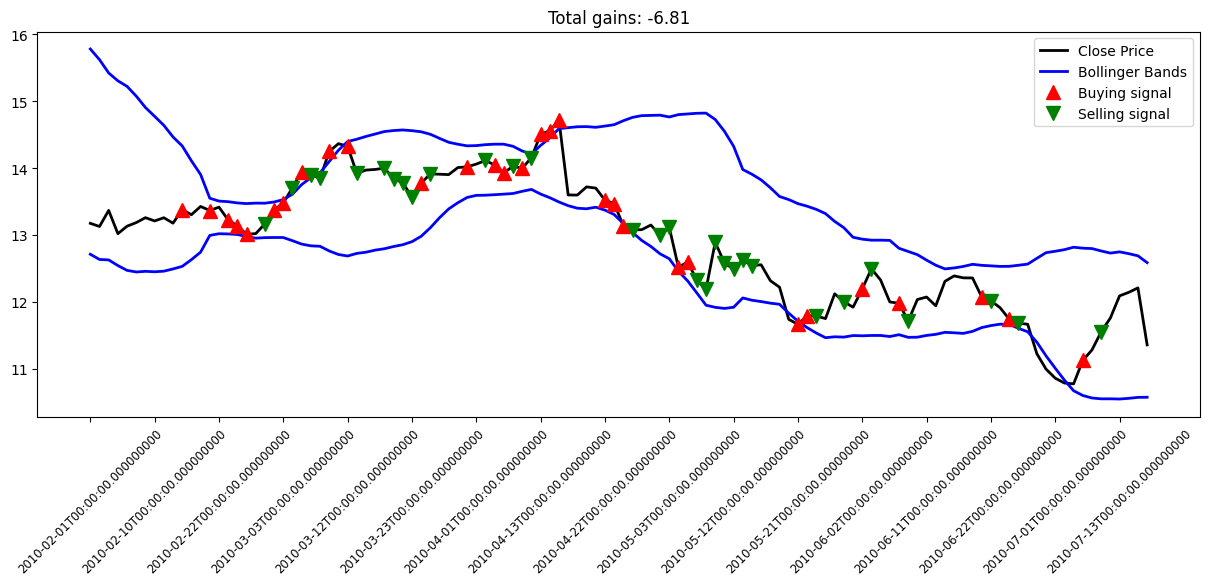

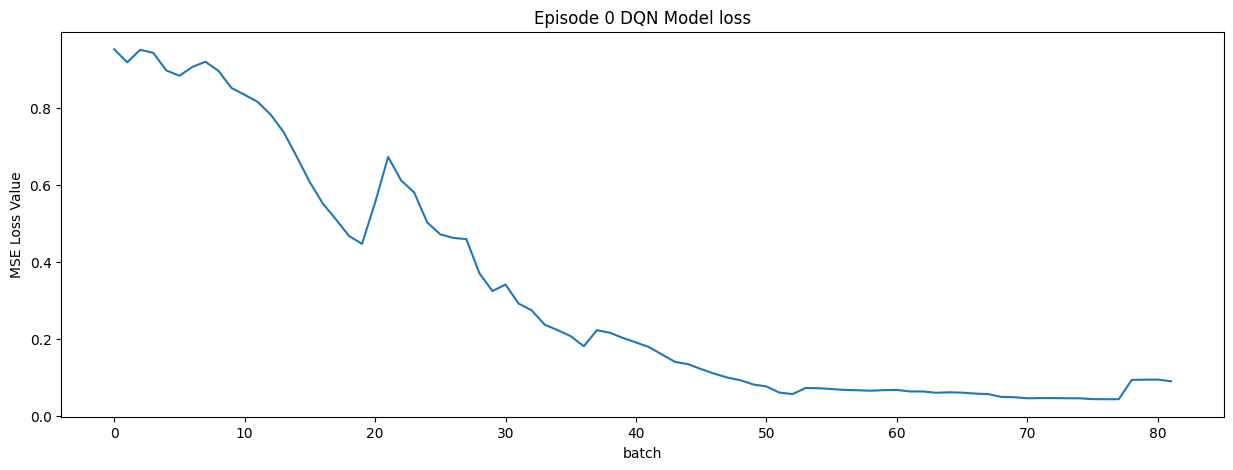

Running episode 1/1:   0%|          | 0/115 [00:00<?, ?it/s]

Buy: $13.37
Sell: $13.02 | Profit: -$0.35
Buy: $13.19
Buy: $13.26
Buy: $13.21
Buy: $13.38
Sell: $13.37 | Profit: $0.18
Sell: $13.42 | Profit: $0.16
Sell: $13.23 | Profit: $0.02
Sell: $13.14 | Profit: -$0.24
Buy: $13.48
Buy: $13.71
Sell: $13.95 | Profit: $0.47
Sell: $13.85 | Profit: $0.14
Buy: $14.25
Sell: $14.37 | Profit: $0.12
Buy: $14.51
Sell: $14.56 | Profit: $0.06
Buy: $14.72
Sell: $13.60 | Profit: -$1.12
Buy: $13.52
Buy: $13.08
Sell: $13.00 | Profit: -$0.53
Sell: $12.52 | Profit: -$0.56
Buy: $12.32
Sell: $11.67 | Profit: -$0.65
Buy: $12.12
Buy: $12.01
Buy: $11.92
Sell: $12.50 | Profit: $0.37
Sell: $12.33 | Profit: $0.32
Sell: $12.00 | Profit: $0.08
Buy: $12.36
Sell: $12.08 | Profit: -$0.28
--------------------------------------------------------------
Episode 1
Total Profit -$1.83
Total Winners $1.91
Total Losers -$8.08
Max Loss: 0.3287315222983338
Total Loss: 9.916123108809828
--------------------------------------------------------------


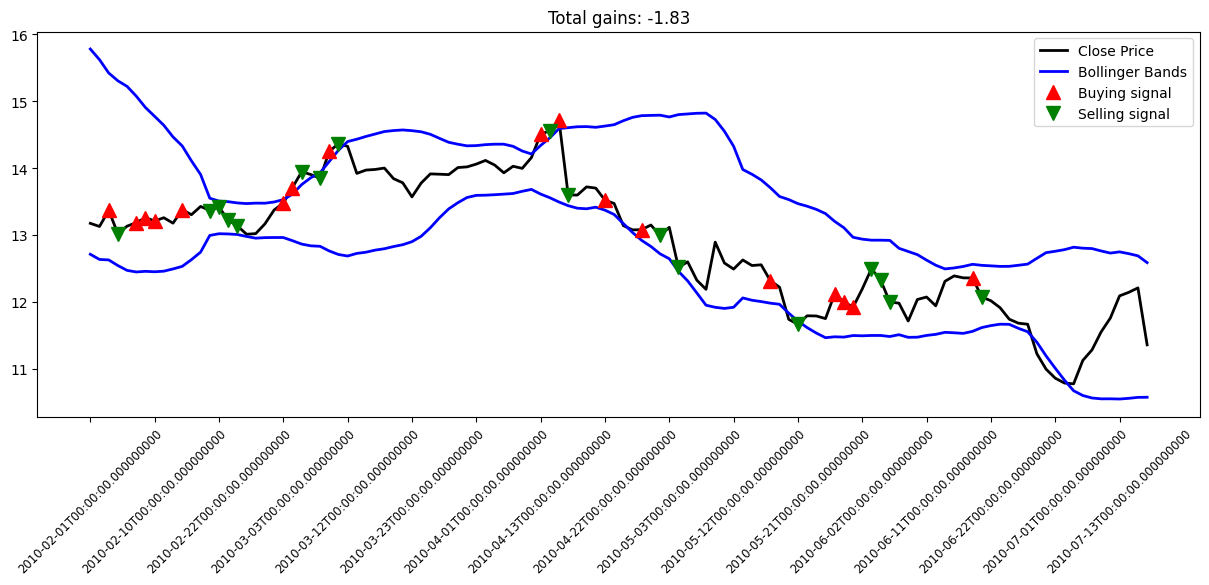

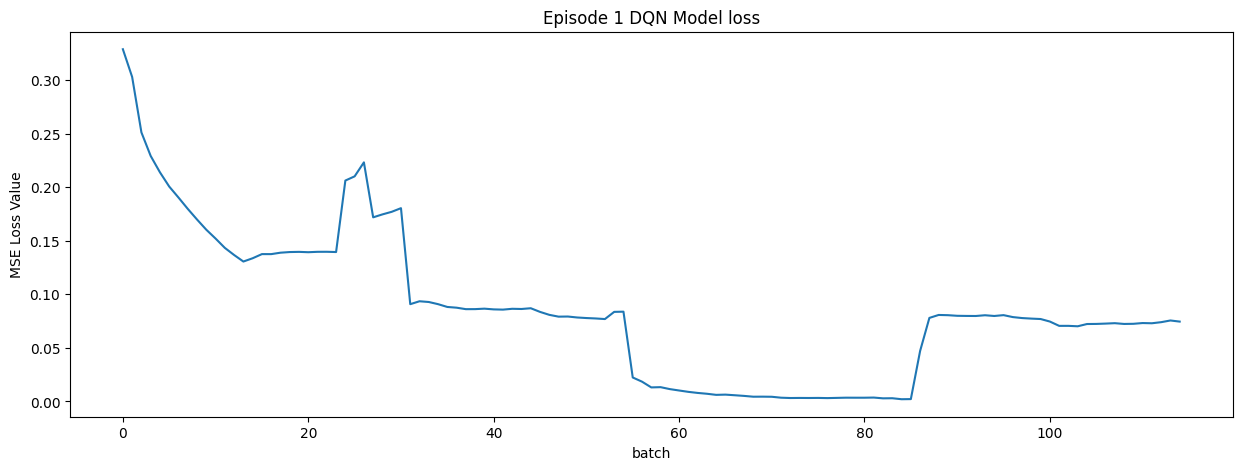

In [28]:
keras.config.disable_traceback_filtering() # Disable keras loading bar to improve the readability
keras.utils.disable_interactive_logging()

# Track number of examples in dataset (Number of days to train on)
l = X_train[:,0].shape[0] - 1

# batch size defines how often to run the exp_replay method
batch_size = 32

# An episode represents a complete pass over the data.
episode_count = 1

# Get the normalizer values from normlist
normalizer_close = normlist[idx_close]
normalizer_bb_upper = normlist[idx_bb_upper]
normalizer_bb_lower = normlist[idx_bb_lower]

# inverse transform values in X_train in order to get true values
X_train_true_price = normalizer_close.inverse_transform(X_train[:,idx_close].reshape(-1, 1))
X_train_true_bb_upper = normalizer_bb_upper.inverse_transform(X_train[:, idx_bb_upper].reshape(-1, 1))
X_train_true_bb_lower = normalizer_bb_lower.inverse_transform(X_train[:, idx_bb_lower].reshape(-1, 1))

batch_losses = []
num_batches_trained = 0

for e in range(episode_count + 1):
    state = get_state(X_train, 0, window_size+1)
    # Initialize variables
    total_profit = 0
    total_winners = 0
    total_losers = 0
    agent.inventory = []
    states_sell = []
    states_buy = []
    for t in tqdm(range(l), desc=f'Running episode {e}/{episode_count}'):
        action = agent.act(state)
        next_state = get_state(X_train, t+1, window_size + 1)
        
        # initialize reward for current time stamp
        reward = 0
        
        if action == 1: # buy
            # inverse transform to get true buy price in dollars
            # buy_price = X_train[t, idx_close]
            buy_price = normalizer_close.inverse_transform([[X_train[t, idx_close]]])[0][0]
            agent.inventory.append(buy_price)
            states_buy.append(t)
            print(f'Buy: {format_price(buy_price)}')
            
        elif action == 2 and len(agent.inventory) > 0: # Sell
            bought_price = agent.inventory.pop(0)
            # inverse transform to get the true sell price in dollars
            # sell_price = X_train[t, idx_close]
            sell_price = normalizer_close.inverse_transform([[X_train[t, idx_close]]])[0][0]
            
            # define rewards as max of profit (close price at the time of sell - close price at the time of buy) and 0
            trade_profit = sell_price - bought_price
            reward = max(trade_profit, 0)
            total_profit += trade_profit
            if trade_profit >= 0:
                total_winners += trade_profit
            else:
                total_losers += total_profit
            
            states_sell.append(t)
            print(f'Sell: {format_price(sell_price)} | Profit: {format_price(trade_profit)}')
            
        # flag for final training iteration
        done = True if t == l - 1 else False
        
        # append the details of the state action etc in the memory to be used by he exp_replay function
        agent.memory.append((state, action, reward, next_state, done))
        state = next_state
        # print total profit and plot behaviour of the current episode when the episode is finished
        if done:
            print('--------------------------------------------------------------')
            print(f'Episode {e}')
            print(f'Total Profit {format_price(total_profit)}')
            print(f'Total Winners {format_price(total_winners)}')
            print(f'Total Losers {format_price(total_losers)}')
            print(f'Max Loss: {max(batch_losses[num_batches_trained:len(batch_losses)])}')
            print(f'Total Loss: {sum(batch_losses[num_batches_trained:len(batch_losses)])}')
            print('--------------------------------------------------------------')
            plot_behavior(X_train_true_price, X_train_true_bb_upper, X_train_true_bb_lower, states_buy, states_sell, total_profit)
            plot_losses(batch_losses[num_batches_trained:len(batch_losses)], f'Episode {e} DQN Model loss')
            num_batches_trained = len(batch_losses)
            
        if len(agent.memory) > batch_size:
            # When the size of the memory is greater than the batch size, run the exp_replay function on the batch to fit the model and get losses for the batch
            losses = agent.exp_replay(batch_size)
            # then sum the losses for the batch and append them to the batch_losses list
            batch_losses.append(sum(losses))
            
    agent.model.save(f'/content/drive/MyDrive/model_ep{e}.keras')

# 9. Test the Trained agent

## Define parameters

In [29]:
l_test = len(X_test) - 1
state = get_state(X_test, 0, window_size + 1)
total_profit = 0
done = False
states_sell_test = []
states_buy_test = []

# Get trained model
agent = Agent(window_size, num_features=X_test.shape[1], test_mode=True, model_name=f'/content/drive/MyDrive/model_ep{episode_count}.keras')
agent.inventory = []

state = get_state(X_test, 0, window_size+1)     # Get the first state of the first test dataset

# inverse transform values in X_train in order to get true values
X_test_true_price = normalizer_close.inverse_transform(X_test[:,idx_close].reshape(-1, 1))
X_test_true_bb_upper = normalizer_bb_upper.inverse_transform(X_test[:, idx_bb_upper].reshape(-1, 1))
X_test_true_bb_lower = normalizer_bb_lower.inverse_transform(X_test[:, idx_bb_lower].reshape(-1, 1))

## Run the Test

Buy: $15.27
Sell: $15.03 | Profit: -$0.24
Buy: $15.40
Buy: $15.26
Buy: $14.91
Sell: $14.72 | Profit: -$0.68
Sell: $14.43 | Profit: -$0.83
Sell: $14.43 | Profit: -$0.49
--------------------------------------------------------------
Episode 1
Total Profit -$2.24
--------------------------------------------------------------


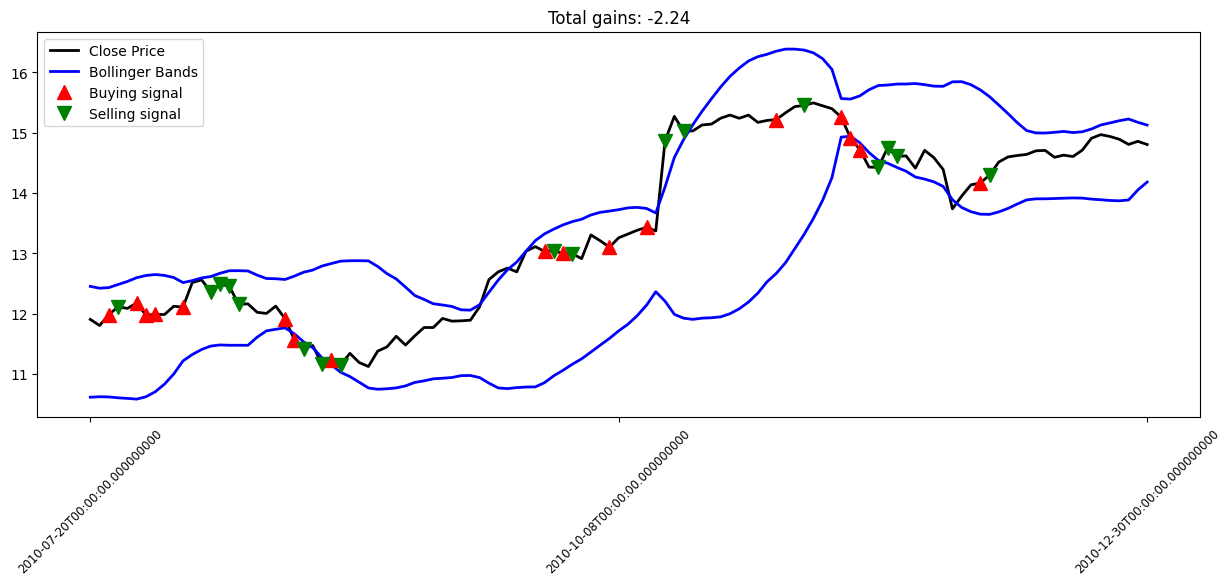

In [30]:
keras.config.disable_traceback_filtering() # Disable keras loading bar to improve the readability
keras.utils.disable_interactive_logging()

for t in range(l_test):
        action = agent.act(state)
        next_state = get_state(X_test, t+1, window_size + 1)
        
        # initialize reward for current time stamp
        reward = 0
        
        if action == 1: # buy
            # inverse transform to get true buy price in dollars
            buy_price = normalizer_close.inverse_transform([[X_test[t, idx_close]]])[0][0]
            agent.inventory.append(buy_price)
            states_buy_test.append(t)
            print(f'Buy: {format_price(buy_price)}')
            
        elif action == 2 and len(agent.inventory) > 0: # Sell
            bought_price = agent.inventory.pop(0)
            # inverse transform to get the true sell price in dollars
            sell_price = normalizer_close.inverse_transform([[X_test[t, idx_close]]])[0][0]
            
            #  rewards is max of profit (close price at the time of sell - close price at the time of buy) and 0
            trade_profit = sell_price - bought_price
            reward = max(trade_profit, 0)
            total_profit += trade_profit
            
            states_sell_test.append(t)
            print(f'Sell: {format_price(sell_price)} | Profit: {format_price(trade_profit)}')
            
        # flag for final training iteration
        if t == l_test - 1:
            done = True
        
        # append the details of the state action etc in the memory to be used by he exp_replay function
        agent.memory.append((state, action, reward, next_state, done))
        state = next_state
        # print total profit and plot behaviour of the current episode when the episode is finished
        if done:
            print('--------------------------------------------------------------')
            print(f'Episode {e}')
            print(f'Total Profit {format_price(total_profit)}')
            # print(f'Total Winners {format_price(total_winners)}')
            # print(f'Total Losers {format_price(total_losers)}')
            print('--------------------------------------------------------------')
plot_behavior(X_test_true_price, X_test_true_bb_upper, X_test_true_bb_lower, states_buy, states_sell, total_profit, train = False)
